# Compute the borders of a MOC

In [1]:
import numpy as np
from mocpy import MOC, WCS

from astropy.wcs.utils import skycoord_to_pixel

import astropy.units as u
from astropy.coordinates import SkyCoord, Angle

from matplotlib.path import Path
from matplotlib.patches import PathPatch
import matplotlib.pyplot as plt

In [2]:
order = 7

fits_path = "../resources/P-GALEXGR6-AIS-FUV.fits"
moc = MOC.from_fits(fits_path)
moc = moc.degrade_to_order(order)

In [3]:
%%time
# Computing time is related to the number of ipixels located in borders of the MOC.
# GALEX has a lot of holes and therefore there are a lot of ipixels lying in its border.
# It's especially true for deeper orders.

# The step taking the most of time is the construction of the graph from the coordinates of the ipixels
# lying in the border of all the dissociated MOC components.

# For the purpose of the demo we reduce the order of GALEX from 8 to 7
boundaries_l = moc.get_boundaries()

<timed exec>:9: DeprecationWarning: This method is not stable. A future more stable algorithm will be implemented!
/home/manon.marchand/.conda/envs/mocpy-tests/lib/python3.11/site-packages/astropy_healpix/core.py:659: RuntimeWarning: invalid value encountered in neighbours_nested
  return np.stack(func(healpix_index, nside))


CPU times: user 1.26 s, sys: 37.9 ms, total: 1.3 s
Wall time: 1.31 s


In [4]:
def get_cmap(n, name="hsv"):
    """Return a colormap.

    This function maps each index in 0, 1, ..., n-1 to a distinct
    RGB color; the keyword argument name must be a standard matplotlib
    colormap name.
    """
    return plt.cm.get_cmap(name, n)


def add_patch_path(ax, wcs, coords, **kw_mpl_pathpatch):
    """Define a custom implementation of ``MOC.fill()``."""
    xp, yp = skycoord_to_pixel(coords=coords, wcs=wcs)
    xp = xp.flatten()
    yp = yp.flatten()
    codes = np.ones(shape=(xp.shape[0] + 1,)) * Path.LINETO
    codes[0] = Path.MOVETO
    codes[-1] = Path.CLOSEPOLY

    vertices = np.vstack((xp, yp)).T.tolist()
    vertices.append(vertices[0])

    path = Path(vertices, codes)

    patch = PathPatch(path, **kw_mpl_pathpatch)
    ax.add_patch(patch)

/tmp/ipykernel_359807/573143703.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return plt.cm.get_cmap(name, n)


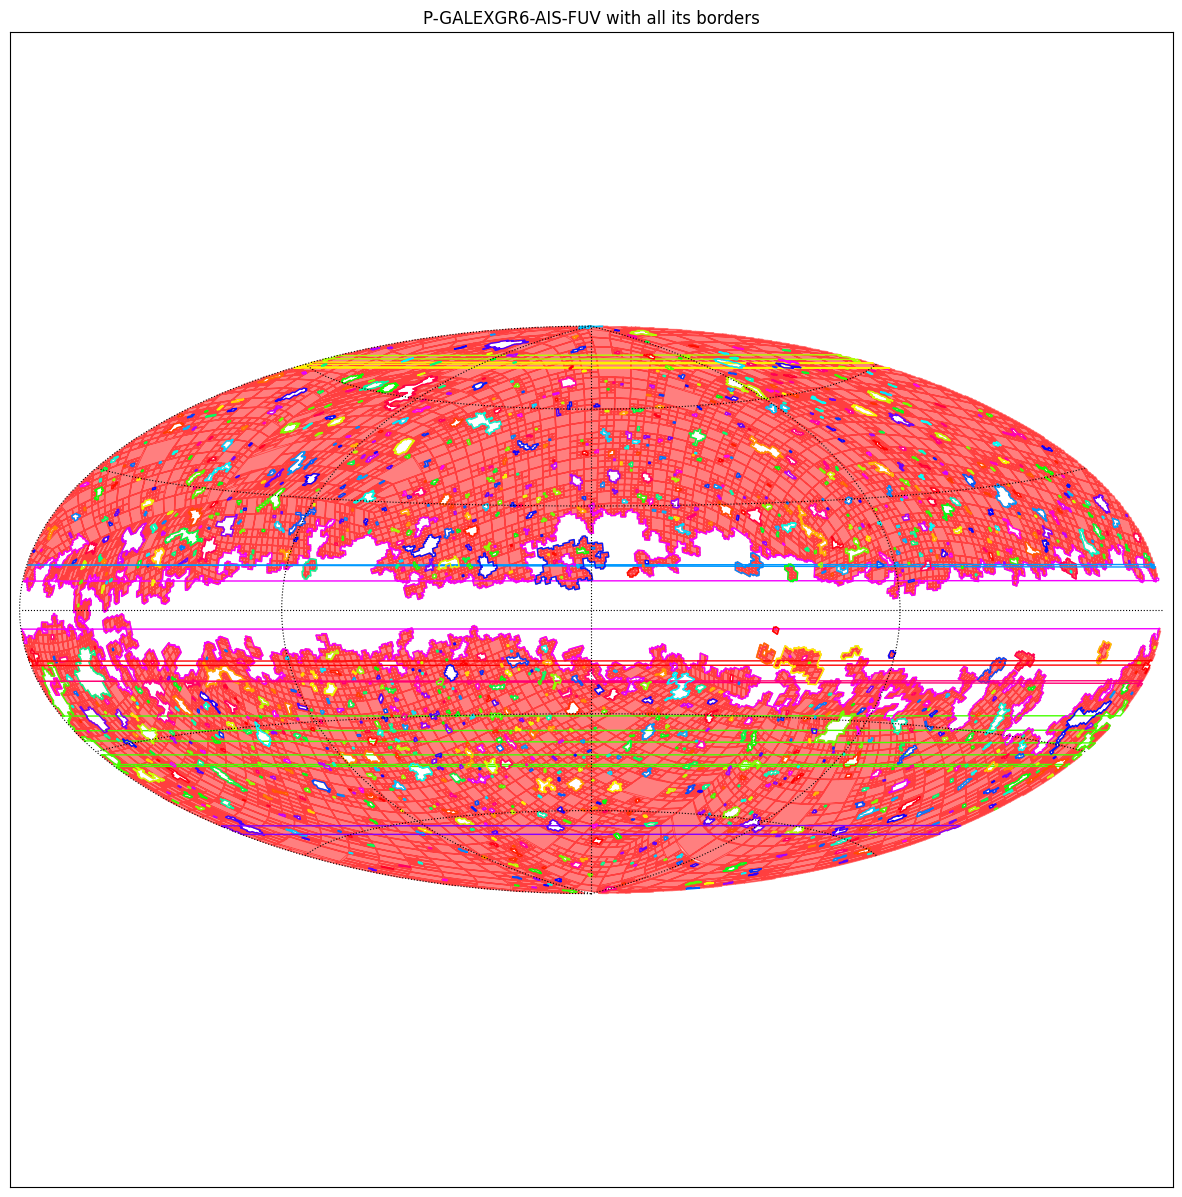

In [5]:
fig = plt.figure(111, figsize=(15, 15))
cmap = get_cmap(100)

with WCS(
    fig,
    fov=330 * u.deg,
    center=SkyCoord(0, 0, unit="deg", frame="galactic"),
    coordsys="galactic",
    rotation=Angle(0, u.degree),
    projection="AIT",
) as wcs:
    ax = fig.add_subplot(1, 1, 1, projection=wcs)

    moc.fill(ax=ax, wcs=wcs, alpha=0.5, fill=True, color="r")
    # Draw the borders, each plotted in a different color.
    for border_coords in boundaries_l:
        add_patch_path(
            ax=ax,
            wcs=wcs,
            coords=border_coords,
            fill=False,
            color=cmap(np.random.randint(100)),
        )

plt.xlabel("ra")
plt.ylabel("dec")
plt.title("P-GALEXGR6-AIS-FUV with all its borders")
plt.grid(color="black", linestyle="dotted")
# The lines cutting the MOC are borders passing from the extreme east to the extreme west of the projection
plt.show()